In [40]:
TODO:
    

train, test
linear model
NN model
custom nn components (custom autograd, init weights, dropout, learning rate decay)
toggle with ipywidgets
crayon

In [269]:
import os
import sys
import random
import time
import numpy as np
import matplotlib.pyplot as plt

In [84]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import (
    Variable,
)
from torch.nn import (
    init,
)

In [265]:
def plot_model(X, y, w1, b1, w2, b2):
    """
    Plot the model.
    """
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], w1) + b1), w2) + b2
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

### Create the data

In [223]:
random.seed(seed)
torch.manual_seed(seed=1234)
N = 1000 # num_samples_per_class
D = 2 # dimensions
C = 3 # num_classes
H = 100 # num_hidden_units

In [159]:
X = torch.zeros((N*C, D))
y = torch.zeros((N*C))
for i in range(C):
    index = 0
    r = torch.linspace(0, 1, N)
    t = torch.linspace(i*4,(i+1)*4,N) + torch.randn(N)*0.1
    for ix in range(N*i, N*(i+1)):
        X[ix] = torch.FloatTensor(
            (r[index]*np.sin(t[index]), r[index]*np.cos(t[index])), )
        y[ix] = i
        index += 1

print ("SHAPES:")
print ("-------------------")
print ("X:", X.size())
print ("y:", y.size())    

SHAPES:
-------------------
X: torch.Size([3000, 2])
y: torch.Size([3000])


In [266]:
def plot_data(X, y):
    """
    Plot the data.
    """
    plt.scatter (X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.show ()

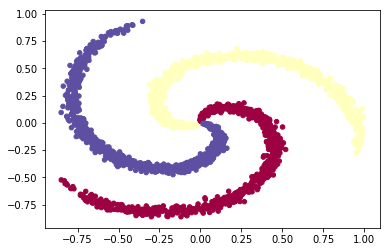

In [267]:
# Create the data
plot_data(X.numpy(), y.numpy())

### Create train/test sets

In [227]:
split_ratio = 0.8 # train-test split
num_epochs = 1000
batch_size = 64
learning_rate = 1.0
log_every = 250

In [217]:
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]
test_start_idx = int(len(X) * split_ratio)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print ("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 2400 train samples and 600 test samples.


In [218]:
# Join X and y
train_data = torch.cat([X_train, y_train], 1)
test_data = torch.cat([X_test, y_test], 1)

In [219]:
# Data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

### Linear model

In [224]:
# Linear model
class LinearModel(nn.Module):
    """
    Linaer model.
    """
    def __init__(self, D_in, H, D_out):
        """
        Initialize weights.
        """
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        Forward pass.
        """
        z = self.fc1(x)
        z = self.fc2(z)
        return z

In [279]:
def process_batch(batch, model, criterion, optimizer, is_training):
    """
    Process a minibatch for loss and accuracy.
    """
    X_batch = batch[:,:2]
    y_batch = batch[:, 2]

    # Convert tensors to Variables (for autograd)
    X_batch = Variable(X_batch, requires_grad=False)
    y_batch = Variable(y_batch.long(), requires_grad=False)

    # Forward pass
    scores = model(X_batch) # logits

    # Loss
    loss = criterion(scores, y_batch)
    
    # Accuracy
    score, predicted = torch.max(scores, 1)
    accuracy = (y_batch.data == predicted.data).sum() / float(len(y_batch))
    
    if is_training:

        # Use autograd to do backprop. This will compute the
        # gradients w.r.t loss for all Variables that have
        # requires_grad=True. So, our w1 and w2 will now have
        # gradient components we can access.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    return loss, accuracy

In [280]:
# Create model
model = LinearModel(D_in=D, H=H, D_out=C)

# Objective
criterion = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training
for num_train_epoch in range(num_epochs):
    
    # Timer
    start = time.time()
    
    # Metrics
    train_batch_loss = 0.0
    train_batch_accuracy = 0.0
    
    for train_batch_num, (train_batch) in enumerate(train_loader):
        
        # Get metrics
        model.train()
        loss, accuracy = process_batch(train_batch, model, criterion, optimizer, model.training)
        
        # Add to batch scalars
        train_batch_loss += loss.data[0] / float(len(X_train_batch))
        train_batch_accuracy += accuracy    

    # Verbose
    if (num_train_epoch == 0) or (num_train_epoch % log_every == 0) or (num_train_epoch == num_epochs-1):
        
        # Testing
        model.eval()
        for num_test_epoch in range(1):
            
            # Metrics
            test_batch_loss = 0.0
            test_batch_accuracy = 0.0
    
            for test_batch_num, (test_batch) in enumerate(test_loader):
        
                # Get metrics
                model.eval()
                loss, accuracy = process_batch(test_batch, model, criterion, optimizer, model.training)
                
                # Add to batch scalars
                test_batch_loss += loss.data[0] / float(len(X_test_batch))
                test_batch_accuracy += accuracy
        
        # Verbose
        time_remain = (time.time() - start) * (num_epochs - (num_train_epoch+1))
        minutes = time_remain // 60
        seconds = time_remain - minutes*60
        print ("TIME REMAINING: %im %is" % (minutes, seconds))
        print ("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f, [TEST LOSS]: %.6f, [TEST ACC]: %.3f" %
               (num_train_epoch, train_batch_loss/float(train_batch_num+1), 
                train_batch_accuracy/float(train_batch_num+1), test_batch_loss/float(test_batch_num+1),
                test_batch_accuracy/float(test_batch_num+1)))

TIME REMAINING: 0m 38s
[EPOCH]: 0, [TRAIN LOSS]: 0.631160, [TRAIN ACC]: 0.496, [TEST LOSS]: 0.154010, [TEST ACC]: 0.429
TIME REMAINING: 0m 25s
[EPOCH]: 250, [TRAIN LOSS]: 0.025451, [TRAIN ACC]: 0.569, [TEST LOSS]: 0.031159, [TEST ACC]: 0.596
TIME REMAINING: 0m 16s
[EPOCH]: 500, [TRAIN LOSS]: 0.023943, [TRAIN ACC]: 0.556, [TEST LOSS]: 0.030930, [TEST ACC]: 0.532
TIME REMAINING: 0m 9s
[EPOCH]: 750, [TRAIN LOSS]: 0.023887, [TRAIN ACC]: 0.563, [TEST LOSS]: 0.030677, [TEST ACC]: 0.545
TIME REMAINING: 0m 0s
[EPOCH]: 999, [TRAIN LOSS]: 0.023810, [TRAIN ACC]: 0.574, [TEST LOSS]: 0.033101, [TEST ACC]: 0.586


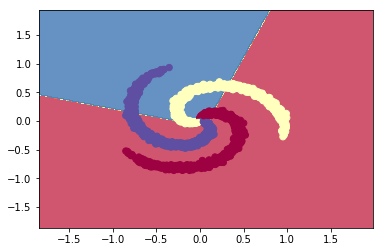

In [281]:
# Plot trained model
plot_model(X.numpy(), y.numpy(),
    torch.transpose(model.fc1.weight.data, 0, 1).numpy(),
    model.fc1.bias.data.numpy(),
    torch.transpose(model.fc2.weight.data, 0, 1).numpy(),
    model.fc2.bias.data.numpy())